# ベクトル可視化
memory_units の Embedding（1024次元）を2Dに圧縮して表示します。

In [6]:
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

conn = psycopg2.connect(host="db", dbname="myfriend", user="postgres", password="postgres")
cur = conn.cursor()

# Embedding付きの記憶を取得
cur.execute("""
    SELECT id, text, fact_type, embedding::text
    FROM memory_units
    WHERE embedding IS NOT NULL
    LIMIT 500
""")
rows = cur.fetchall()
print(f"{len(rows)} 件の記憶を取得")

if len(rows) == 0:
    print("データがありません。まず記憶を保存してください。")
else:
    ids = [r[0] for r in rows]
    texts = [r[1][:50] for r in rows]  # ラベル用に先頭50文字
    types = [r[2] for r in rows]
    embeddings = np.array([list(map(float, r[3].strip('[]').split(','))) for r in rows])
    print(f"Embedding shape: {embeddings.shape}")

9 件の記憶を取得
Embedding shape: (9, 1024)


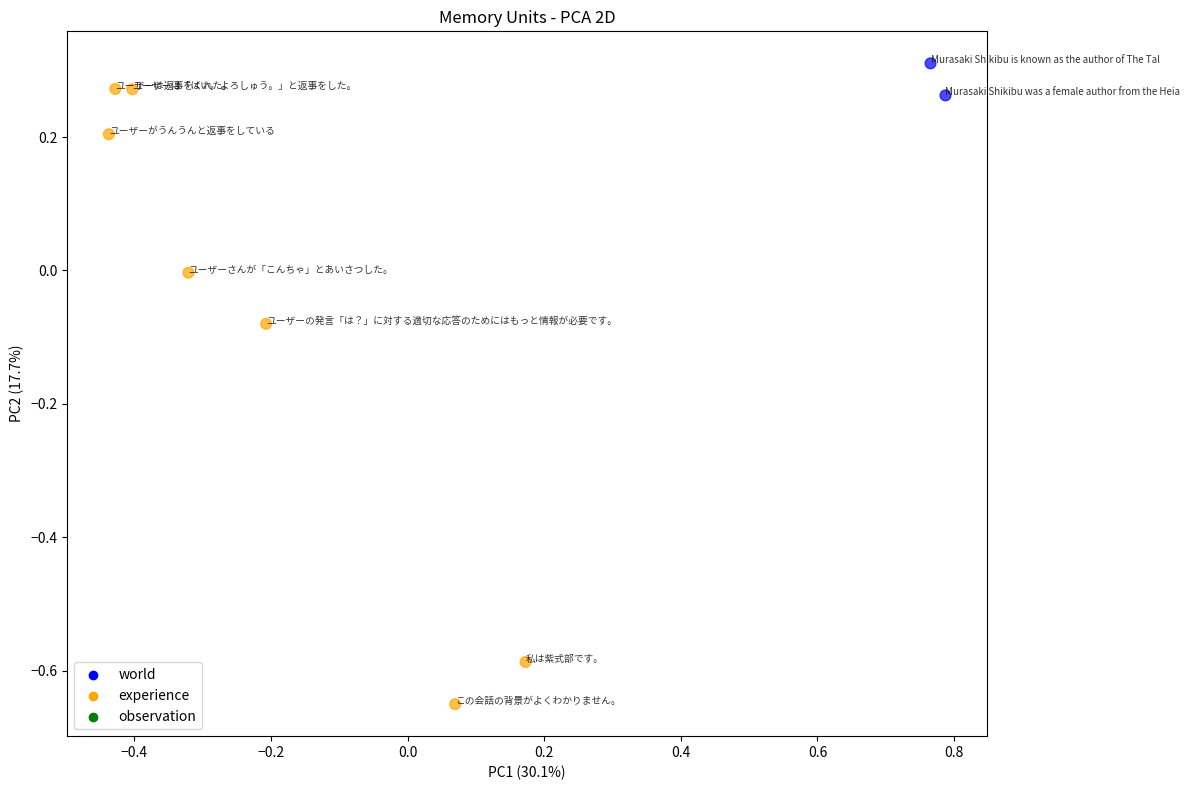

In [7]:
# PCA で2次元に圧縮して散布図を表示
if len(rows) > 0:
    pca = PCA(n_components=2)
    coords = pca.fit_transform(embeddings)

    color_map = {'world': 'blue', 'experience': 'orange', 'observation': 'green'}
    colors = [color_map.get(t, 'gray') for t in types]

    plt.figure(figsize=(12, 8))
    plt.scatter(coords[:, 0], coords[:, 1], c=colors, alpha=0.7, s=60)

    # ラベルを表示（多すぎる場合は間引き）
    step = max(1, len(texts) // 20)
    for i in range(0, len(texts), step):
        plt.annotate(texts[i], (coords[i, 0], coords[i, 1]), fontsize=7, alpha=0.8)

    plt.title('Memory Units - PCA 2D')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

    # 凡例
    for label, color in color_map.items():
        plt.scatter([], [], c=color, label=label)
    plt.legend()
    plt.tight_layout()
    plt.show()

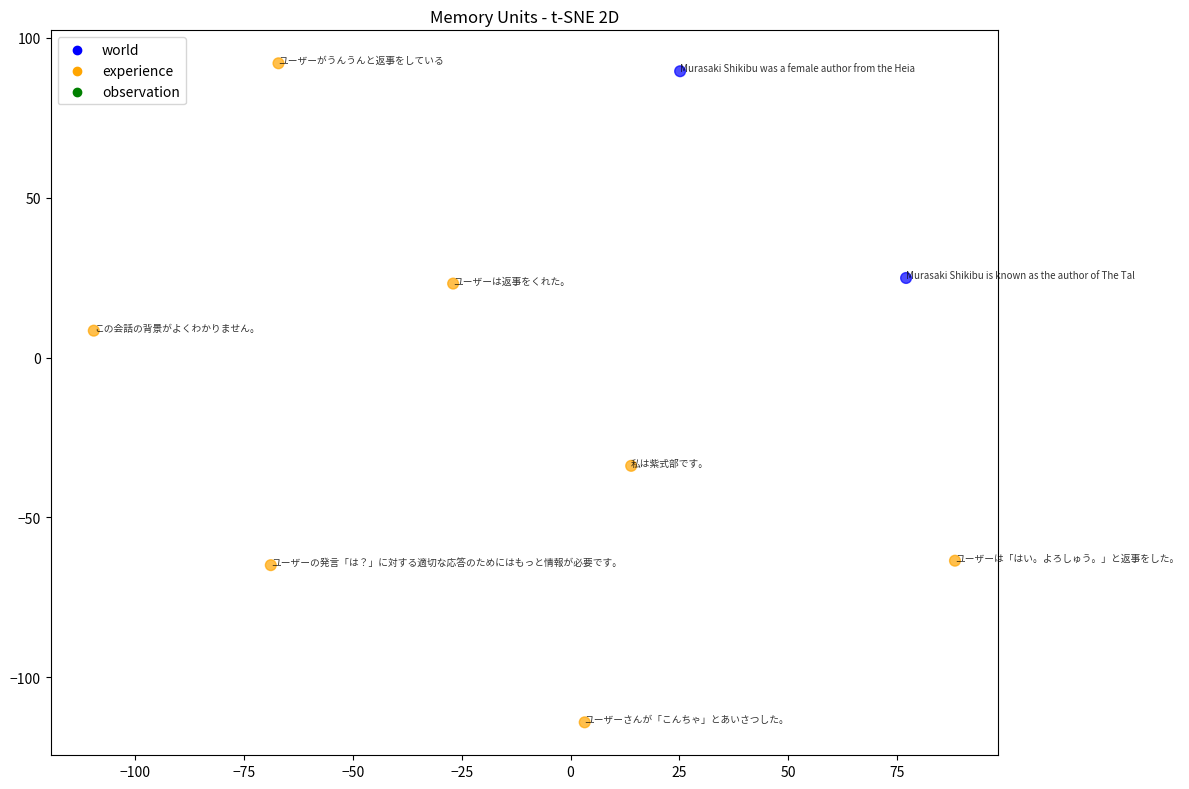

In [8]:
# t-SNE で2次元に圧縮（クラスタがより明確に見える）
if len(rows) >= 5:
    perplexity = min(30, len(rows) - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    coords_tsne = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    plt.scatter(coords_tsne[:, 0], coords_tsne[:, 1], c=colors, alpha=0.7, s=60)

    step = max(1, len(texts) // 20)
    for i in range(0, len(texts), step):
        plt.annotate(texts[i], (coords_tsne[i, 0], coords_tsne[i, 1]), fontsize=7, alpha=0.8)

    plt.title('Memory Units - t-SNE 2D')
    for label, color in color_map.items():
        plt.scatter([], [], c=color, label=label)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("t-SNE にはデータが5件以上必要です")

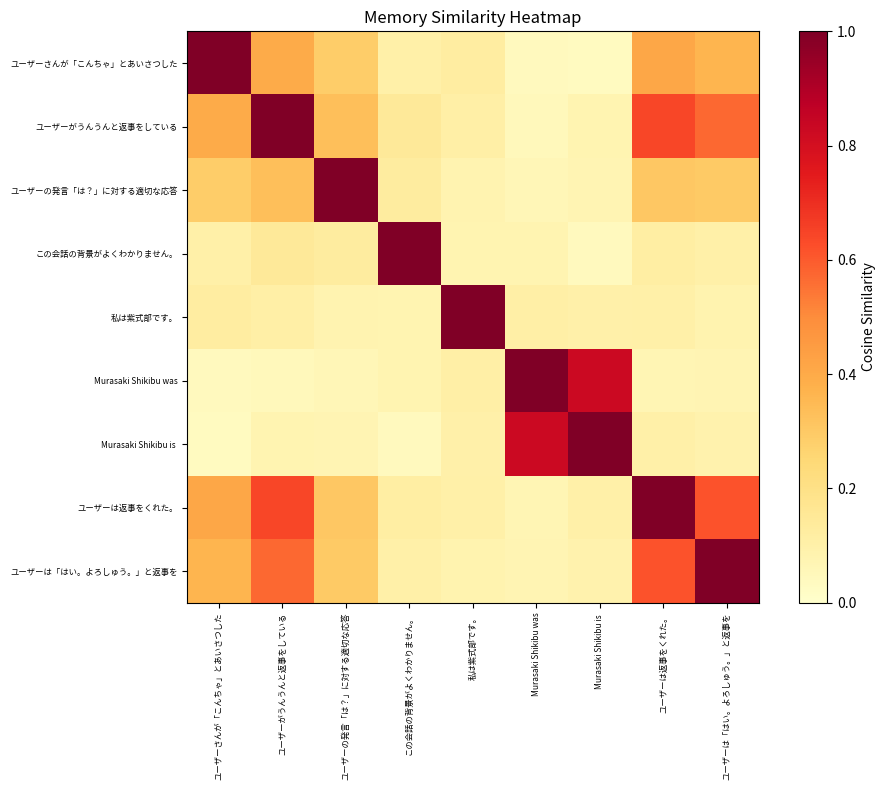

In [9]:
# 類似度マトリクス（ヒートマップ）
if len(rows) > 1:
    from sklearn.metrics.pairwise import cosine_similarity

    sim_matrix = cosine_similarity(embeddings)
    display_n = min(30, len(rows))  # 見やすさのため最大30件

    plt.figure(figsize=(10, 8))
    plt.imshow(sim_matrix[:display_n, :display_n], cmap='YlOrRd', vmin=0, vmax=1)
    plt.colorbar(label='Cosine Similarity')
    plt.xticks(range(display_n), [t[:20] for t in texts[:display_n]], rotation=90, fontsize=6)
    plt.yticks(range(display_n), [t[:20] for t in texts[:display_n]], fontsize=6)
    plt.title('Memory Similarity Heatmap')
    plt.tight_layout()
    plt.show()

In [10]:
cur.close()
conn.close()
print("接続を閉じました")

接続を閉じました
